In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Učitavanje obrađenih podataka

In [2]:
df = pd.read_csv('preprocessed_data.csv')
df = df.drop(columns = 'num')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0.0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,1.0
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1.0
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0.0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0.0


# Završna priprema podataka

Prvo ćemo nadopuniti nedostajuće vrijednosti kNN algoritmom.

In [3]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

Razdvajamo podatke na primjere i oznake i funkciju skaliranja. Koristit ćemo skalirane podatke za predviđanje

In [4]:
y = df.loc[:, 'target']
X = df.drop(columns = 'target')

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

Definirat ćemo funkciju koja ocjenjuje modele ispisivanjem matrice zabune, AUC/ROC krivulje, točnosti

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, X, y):
    # Računanje površine ispod krivulje
    y_pred = cross_val_predict(model, X, y, cv=10)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    # Crtanje ROC krivulje
    plt.plot(fpr, tpr, color='darkorange', label= f'Površina ispod krivulje = {round(roc_auc, 2)}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Lažno pozitivni')
    plt.ylabel('Ispravno pozitivni')
    plt.title('ROC krivulja')
    plt.legend(loc='best')
    plt.show()
    
    # Ispis točnosti
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy Score:', round(accuracy,2))
    
    # Ispis matrice zabune
    conf_matrix = confusion_matrix(y, y_pred)
    print('\nConfusion Matrix:\n', conf_matrix)

    # Ispis jos nekih kljucnih metrika klasifikacije
    class_report = classification_report(y, y_pred)
    print('\nClassification Report:\n', class_report)

# Decision Tree

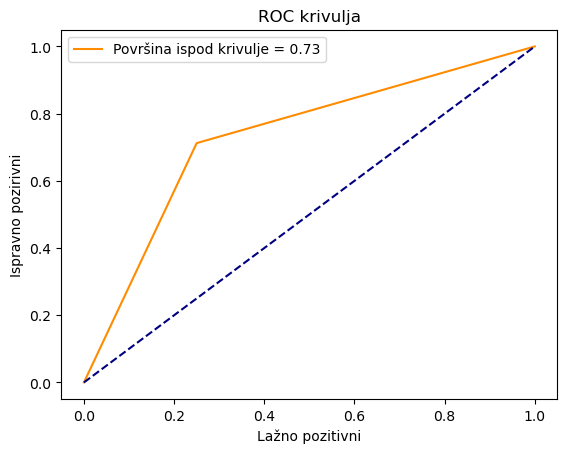

Accuracy Score: 0.73

Confusion Matrix:
 [[123  41]
 [ 40  99]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       164
         1.0       0.71      0.71      0.71       139

    accuracy                           0.73       303
   macro avg       0.73      0.73      0.73       303
weighted avg       0.73      0.73      0.73       303



In [7]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
evaluate_model(model, X, y)

Optimizirajmo parametre i evaluirajmo model s najboljim parametrima. Evaluacijska funkcija je "Accuracy score", dakle proći ćemo kroz različite parametre i odabrati one za koje je model najtočniji

In [9]:
# moguci parametri modela
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']

Optimalni parametri su: entropy best


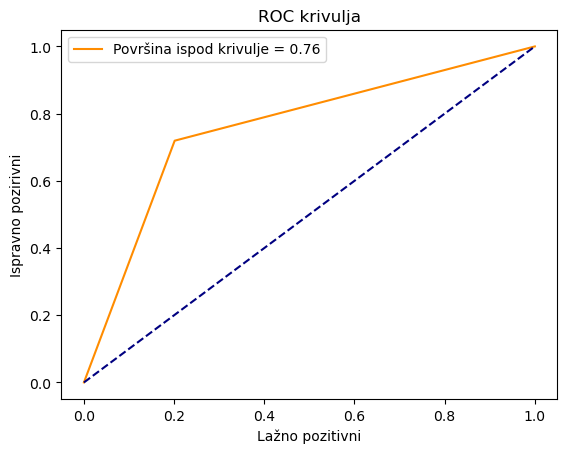

Accuracy Score: 0.76

Confusion Matrix:
 [[131  33]
 [ 39 100]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       164
         1.0       0.75      0.72      0.74       139

    accuracy                           0.76       303
   macro avg       0.76      0.76      0.76       303
weighted avg       0.76      0.76      0.76       303



In [14]:
accuracy = 0
c_opt = None
s_opt = None
# Prolazimo kroz sve moguće kombinacije parametara kako bi našli najbolje
for c in criterion:
    for s in splitter:
        model = DecisionTreeClassifier(criterion = c, splitter = s)
        y_pred = cross_val_predict(model, X, y, cv=10)
        if accuracy_score(y, y_pred) > accuracy:
            accuracy = accuracy_score(y, y_pred)
            c_opt = c
            s_opt = s
print('Optimalni parametri su:', c_opt, s_opt)
# Evaluiramo model za najbolje parametre
model = DecisionTreeClassifier(criterion = c_opt, splitter = s_opt)
evaluate_model(model, X, y)

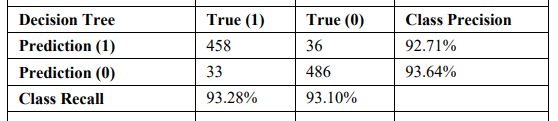

Vidimo da je proces poboljšavanja modela promjenom parametara dao bolji rezultat modela od zadanog. Rezultat i dalje nije ni blizu onome kojeg je autor dobio.

# Naive Bayes

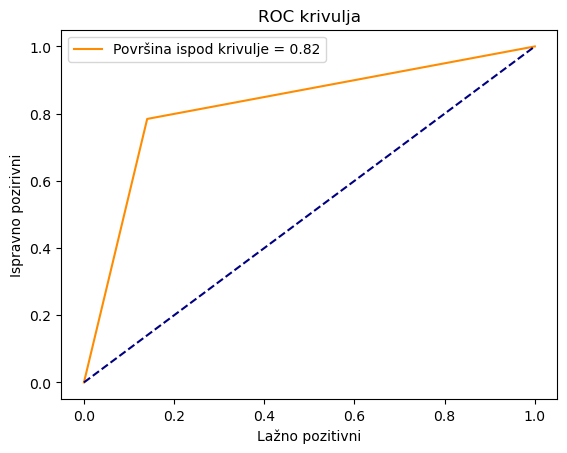

Accuracy Score: 0.83

Confusion Matrix:
 [[141  23]
 [ 30 109]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       164
         1.0       0.83      0.78      0.80       139

    accuracy                           0.83       303
   macro avg       0.83      0.82      0.82       303
weighted avg       0.83      0.83      0.82       303



In [16]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
evaluate_model(model, scaled_X, y)

S obzirom da GaussianNB() prima jedino parametre priors i var_smoothing, a mi ne znamo apriorne vjerojatnosti klasa, probat ćemo samo vidjeti kako var_smoothing utječe na izlaze i točnost modela

Optimalni parametar je: 0.25


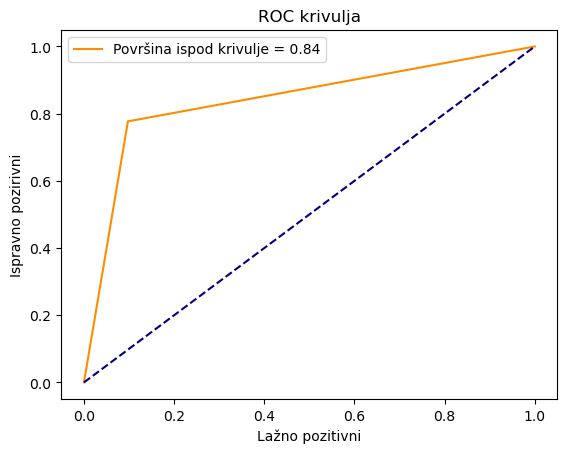

Accuracy Score: 0.84

Confusion Matrix:
 [[148  16]
 [ 31 108]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       164
         1.0       0.87      0.78      0.82       139

    accuracy                           0.84       303
   macro avg       0.85      0.84      0.84       303
weighted avg       0.85      0.84      0.84       303



In [22]:
accuracy = 0
v_opt = None
for i in range(40):
    model = GaussianNB(var_smoothing = 0.5**i)
    y_pred = cross_val_predict(model, scaled_X, y, cv=10)
    if accuracy_score(y, y_pred) > accuracy:
        accuracy = accuracy_score(y, y_pred)
        v_opt = 0.5**i
print('Optimalni parametar je:', v_opt)
model = GaussianNB(var_smoothing = v_opt)
evaluate_model(model, scaled_X, y)

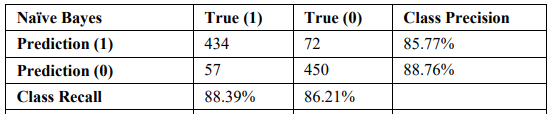
Ovaj model već daje rezultate slične onima koje je dobio autor. I dalje smo malo lošiji, ali puno bliže nego sa stablom odluke.

# Random Forrest

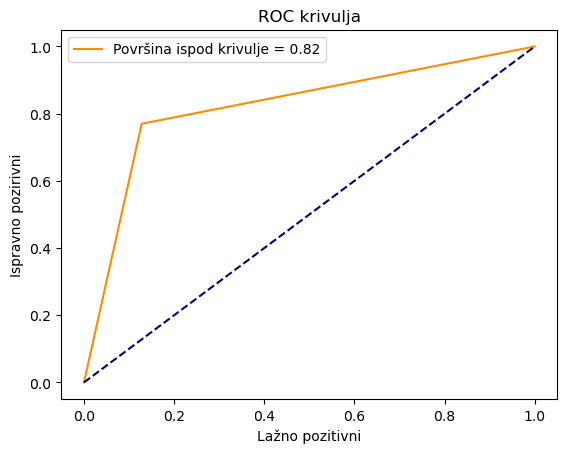

Accuracy Score: 0.83

Confusion Matrix:
 [[143  21]
 [ 32 107]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       164
         1.0       0.84      0.77      0.80       139

    accuracy                           0.83       303
   macro avg       0.83      0.82      0.82       303
weighted avg       0.83      0.83      0.82       303



In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
evaluate_model(model, scaled_X, y)

In [38]:
n_estimators = [50, 100, 200]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [2, 3]
# nakon nekoliko testiranja vidjeli smo da parametri max_depth manji od 2 i veći od 3
# ne pridonose poboljšanju točnosti, pa ćemo birati između te dvije mogućnosti

Optimalni parametri su: 100 entropy 3


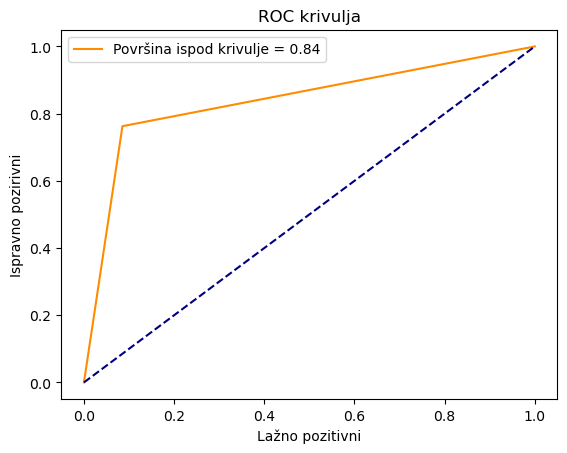

Accuracy Score: 0.84

Confusion Matrix:
 [[150  14]
 [ 33 106]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       164
         1.0       0.88      0.76      0.82       139

    accuracy                           0.84       303
   macro avg       0.85      0.84      0.84       303
weighted avg       0.85      0.84      0.84       303



In [39]:
accuracy = 0
for n in n_estimators:
    for c in criterion:
        for m in max_depth:
            model = RandomForestClassifier(n_estimators = n,
                                           criterion = c,
                                           max_depth = m)
            y_pred = cross_val_predict(model, scaled_X, y, cv=10)
            if accuracy_score(y, y_pred) > accuracy:
                accuracy = accuracy_score(y, y_pred)
                n_opt = n
                c_opt = c
                m_opt = m
print('Optimalni parametri su:', n_opt, c_opt, m_opt)
model = RandomForestClassifier(n_estimators = n, criterion = c, max_depth = m)
evaluate_model(model, scaled_X, y)

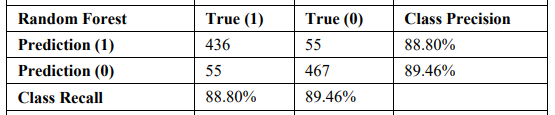
Vidimo da je svaka optimizacija malo popravila točnost modela, ali ponovno je to za oko 5% lošije od autorovog.

# Logistic Regression

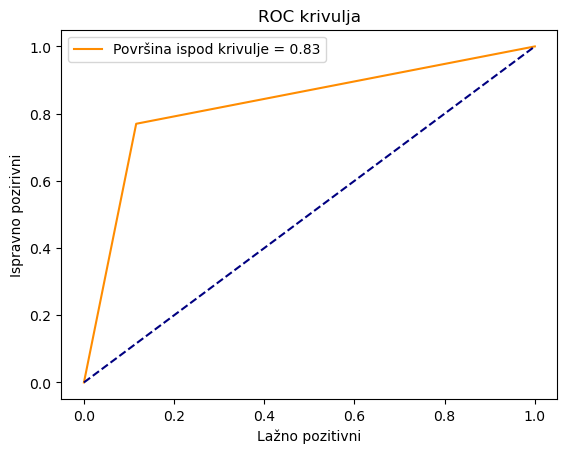

Accuracy Score: 0.83

Confusion Matrix:
 [[145  19]
 [ 32 107]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       164
         1.0       0.85      0.77      0.81       139

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
evaluate_model(model, scaled_X, y)

In [51]:
penalty = ['l1', 'l2']
c_range = range(-5, 5)
max_iter = [50, 100, 200, 500]

Optimalni parametri su: l1 0.125 50


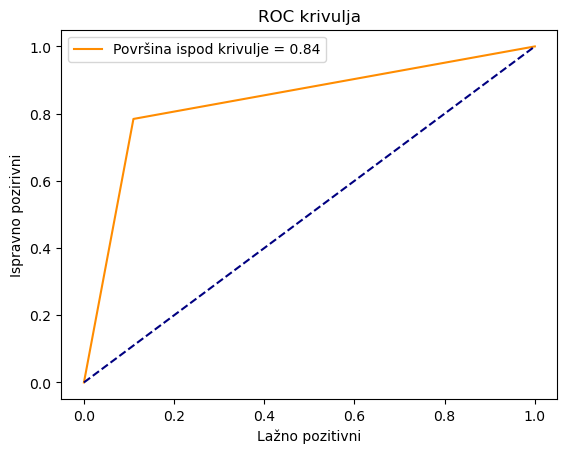

Accuracy Score: 0.84

Confusion Matrix:
 [[146  18]
 [ 30 109]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       164
         1.0       0.86      0.78      0.82       139

    accuracy                           0.84       303
   macro avg       0.84      0.84      0.84       303
weighted avg       0.84      0.84      0.84       303



In [52]:
accuracy = 0
for p in penalty:
    for c in c_range:
        for m in max_iter:
            try:
                model = LogisticRegression(penalty = p, C = 2**c, max_iter = m, solver = 'liblinear')
                y_pred = cross_val_predict(model, scaled_X, y, cv=10)
            except:
                continue
            if accuracy_score(y, y_pred) > accuracy:
                accuracy = accuracy_score(y, y_pred)
                p_opt = p
                c_opt = 2**c
                m_opt = m
print('Optimalni parametri su:', p_opt, c_opt, m_opt)
model = LogisticRegression(penalty = p_opt, C = c_opt, max_iter = m_opt, solver = 'liblinear')
evaluate_model(model, scaled_X, y)

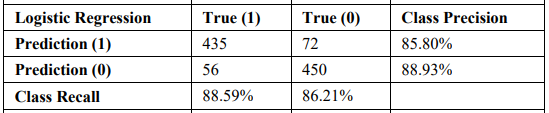

# SVM

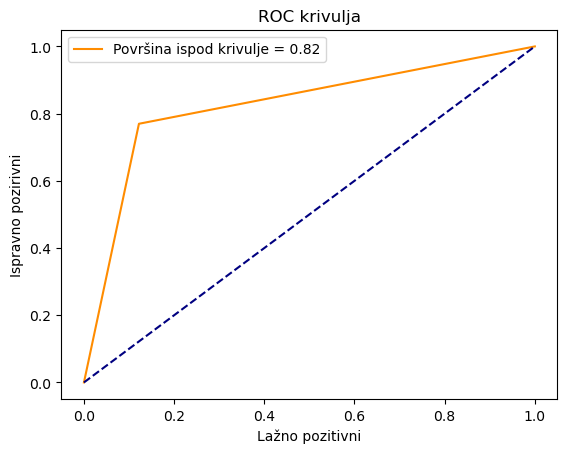

Accuracy Score: 0.83

Confusion Matrix:
 [[144  20]
 [ 32 107]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       164
         1.0       0.84      0.77      0.80       139

    accuracy                           0.83       303
   macro avg       0.83      0.82      0.83       303
weighted avg       0.83      0.83      0.83       303



In [7]:
from sklearn.svm import SVC

model = SVC()
evaluate_model(model, scaled_X, y)

In [8]:
c_range = range(-8,1)
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [14]:
accuracy = 0
for c in c_range:
    for k in kernel:
        try:
            model = SVC(C = 2**c, kernel = k)
            y_pred = cross_val_predict(model, scaled_X, y, cv=10)
        except:
            continue
        if accuracy_score(y, y_pred) > accuracy:
            accuracy = accuracy_score(y, y_pred)
            k_opt = k
            c_opt = 2**c
print('Optimalni parametri su:', k_opt, c_opt)

Optimalni parametri su: linear 0.0625


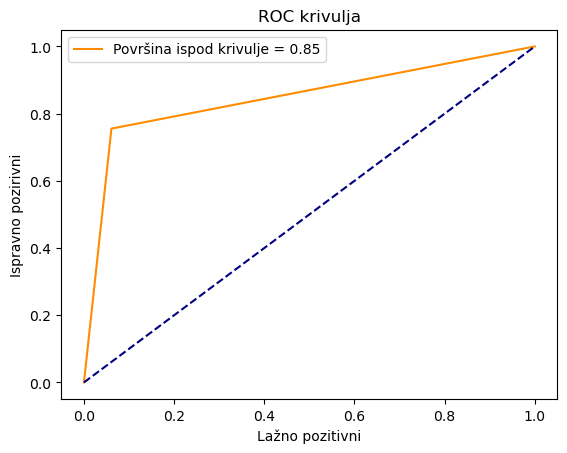

Accuracy Score: 0.85

Confusion Matrix:
 [[154  10]
 [ 34 105]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.94      0.88       164
         1.0       0.91      0.76      0.83       139

    accuracy                           0.85       303
   macro avg       0.87      0.85      0.85       303
weighted avg       0.86      0.85      0.85       303



In [15]:
model = SVC(kernel = k_opt, C = c_opt)
evaluate_model(model, scaled_X, y)

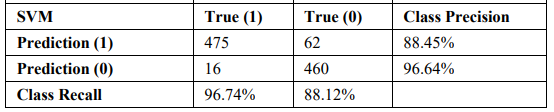
Za model SVM-a imamo poprilično veliku promjenu točnosti optimizacijom parametara, no taj je model i autoru među boljima, pa ponovno imamo odstupanje u rezultatu.

# Zaključak

Isprobali smo svaki od pet algoritama strojnog učenja koji se spominju u članku. <br><br>
Kada ne bi imali članak za usporedbu, rekao bih da bi rezultati bili jako dobri, što možemo vidjeti ako usporedimo s istraživanjem iz 2019. koje se u članku koristi za usporedbu rezultata. S obzirom da su se za rad iz 2019. koristile i metode za odabir značajki, a mi ovdje i bez toga imamo vrlo sličan rezultat, uvjeren sam da uz dobar feature engineering možemo dobiti još bolje rezultate.<br><br>
Vratimo se na zadani članak. S obzirom da smo koristili '10-fold cross validation', različite brojeve iteracija i bili u potrazi za optimalnim parametrima, jedina uočljiva razlika je nasumično proširivanje dataseta. Autor nigdje nije naveo točne metode nasumičnog proširivanja i jesu li nasumično generirane i oznake primjera, pa je sam proces proširivanja bilo teško smisleno replicirati. <br><br>
Ostaje pitanje je li autor dobio bolje rezultate zbog većeg broja primjera u skupu za učenje ili su primjeri i oznake bili generirani tako da na neki način pomognu autoru dobiti bolje rezultate.